Loading the dataset following instructions on the website:

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
statlog_landsat_satellite = fetch_ucirepo(id=146)

# data (as pandas dataframes)
X = statlog_landsat_satellite.data.features
y = statlog_landsat_satellite.data.targets

# metadata
print(statlog_landsat_satellite.metadata)

# variable information
print(statlog_landsat_satellite.variables)


{'uci_id': 146, 'name': 'Statlog (Landsat Satellite)', 'repository_url': 'https://archive.ics.uci.edu/dataset/146/statlog+landsat+satellite', 'data_url': 'https://archive.ics.uci.edu/static/public/146/data.csv', 'abstract': 'Multi-spectral values of pixels in 3x3 neighbourhoods in a satellite image, and the classification associated with the central pixel in each neighbourhood', 'area': 'Climate and Environment', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 6435, 'num_features': 36, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Wed Feb 14 2024', 'dataset_doi': '10.24432/C55887', 'creators': ['Ashwin Srinivasan'], 'intro_paper': None, 'additional_info': {'summary': "The database consists of the multi-spectral values of pixels in 3x3 neighbourhoods in a satellite image, and the classification as

In [ ]:
print(X.shape)
print(y.shape)

(6435, 36)
(6435, 1)






*  first, i imported all necessary libraries for the different models
*   then we convert all the categorical label names to numbers/indexes
*   as given in the description of the dataset - class 6 is missing.
*   after scaling the features, I did a 70:30 split for training and testing
*   no missing / infinite values were found in the dataset as expected








In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from xgboost import XGBClassifier

# Encode labels numerically
le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = le.classes_
print(class_names) #no sample with class6 shld be observed

#Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test Split 70:30
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_enc, test_size=0.3, random_state=42, stratify=y_enc)

print(np.isnan(X_train).sum())  # Count of NaNs in training features
print(np.isnan(X_test).sum())   # Count of NaNs in testing features
print(np.isnan(y_train).sum())  # Count of NaNs in training labels
print(np.isnan(y_test).sum())   # Count of NaNs in testing labels


[1 2 3 4 5 7]
0
0
0
0


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import numpy as np

models = {
    'Logistic Regression': OneVsRestClassifier(LogisticRegression(max_iter=500, random_state=42)),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Dummy Classifier': DummyClassifier(strategy='prior', random_state=42),
    'Gaussian NB': GaussianNB(),
    'Neural Network': MLPClassifier(max_iter=500, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
}





*   Since ROC and Precision–Recall curve require binary or one-vs-rest encoded outputs, the test labels (y_test) are converted into a binary matrix representation using label_binarize. Each column corresponds to one class, and entries are either 0 or 1 depending on the true class membership.
*   Every model stored in the models dictionary is trained on the training dataset (X_train, y_train) and tested on the unseen test set (X_test). Predictions (y_pred) are generated for performance evaluation.
*  Two performance metrics are computed for each model - Accuracy: The ratio of correctly predicted samples to total samples, Weighted F1-Score: The harmonic mean of precision and recall, weighted by the number of instances in each  class, which accounts for class imbalance.
*  For models that provide class probability estimates (like Logistic Regression or Random Forest), the method predict_proba is used. If this function is not available (e.g., for SVMs with linear kernels),  decision_function is used instead.
* The metrics for all models are consolidated into a Pandas DataFrame (results_df), making it easier to view and compare model performances side by side.







In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import label_binarize

results = []

# Binarize true labels for ROC/PRC (One-vs-Rest style)
y_true = label_binarize(y_test, classes=np.unique(y_train))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1_w = f1_score(y_test, y_pred, average='weighted')

    # Get predicted probabilities or decision scores
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)

    # Store metrics
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Weighted F1-Score': f1_w,
        'y_score': y_score
    })


results_df = pd.DataFrame([
    {'Model': r['Model'], 'Accuracy': r['Accuracy'], 'Weighted F1-Score': r['Weighted F1-Score']}
    for r in results
])

print(results_df)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [07:44:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                 Model  Accuracy  Weighted F1-Score
0  Logistic Regression  0.838426           0.811908
1        Random Forest  0.917141           0.914235
2                  SVM  0.897462           0.895996
3  K-Nearest Neighbors  0.910927           0.909984
4     Dummy Classifier  0.238219           0.091661
5          Gaussian NB  0.793371           0.800111
6       Neural Network  0.899534           0.897629
7              XGBoost  0.917141           0.915578


A dictionary named model_scores is created to store the prediction probability or decision function outputs of each model. The model name acts as the key, and the  prediction scores are the values.

In [ ]:
model_scores = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)
    model_scores[name] = y_score


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [07:45:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Then I generated a single plot displaying the One vs Remaining ROC curves for all six models, averaging the False Positive Rate (FPR) and True Positive Rate (TPR) across all six classes (Macro average ROC).

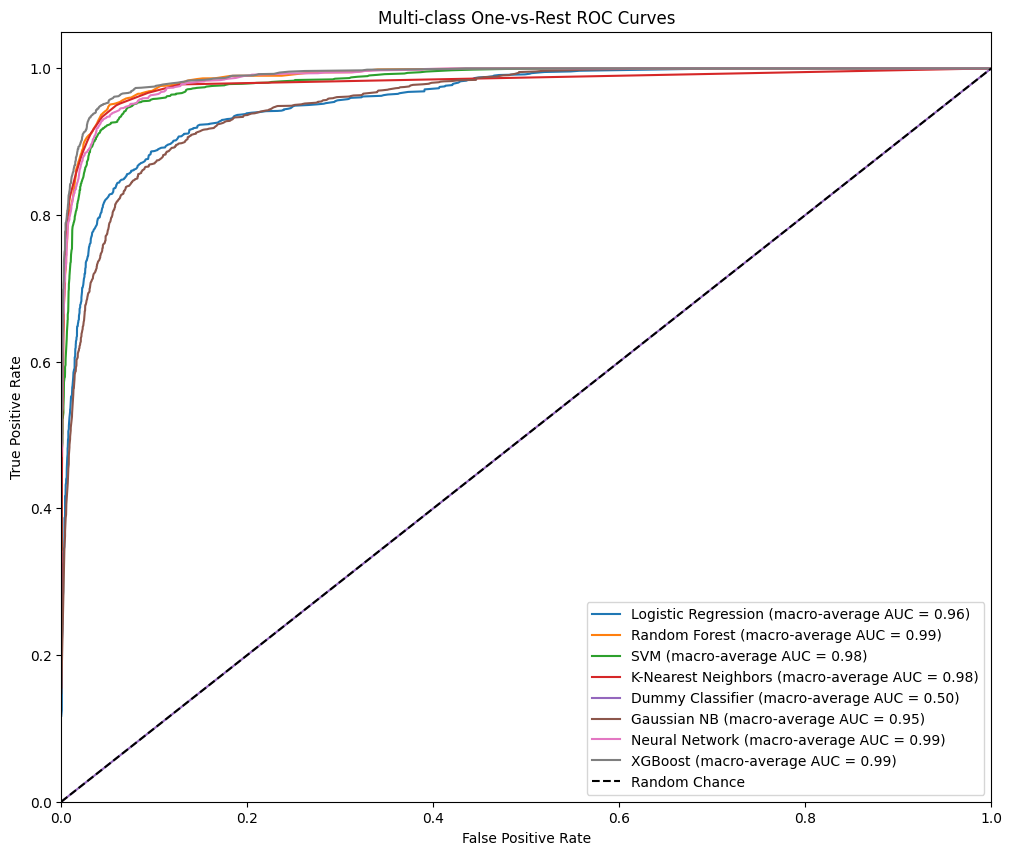

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from numpy  import interp



n_classes = y_true.shape[1]

plt.figure(figsize=(12, 10))

for name, y_score in model_scores.items():
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot macro-average ROC curve
    plt.plot(fpr["macro"], tpr["macro"],
             label=f'{name} (macro-average AUC = {roc_auc["macro"]:0.2f})')

# Plot diagonal line for random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class One-vs-Rest ROC Curves')
plt.legend(loc="lower right")
plt.show()


Among all the models, the Random Forest and Neural Network classifiers achieved the highest macro-averaged AUC values of 0.99. This shows they have a strong ability to distinguish between multiple classes across all decision thresholds. The Dummy Classifier showed a macro-average AUC of 0.50, which corresponds to random guessing. This is expected as a dummy classifier show no real discriminative capability.

An AUC value below 0.5 would mean that the model performs worse than random chance, that is it consistently assigns higher probabilities to incorrect classes. This arises from issues like label inversion, improper model training, or biased data representation. No model evaluated performs poorly.

similar to the roc curves, i generated macro-averaged Precision–Recall (PR) curves for multiple classification models to evaluate their performance on multi-class data. For each model, the precision_recall_curve function computes the precision and recall values in a one-vs-rest (OvR) manner for every class, treating each class as positive once while considering all others as negative. The area under the curve (AUC) for each class is calculated using auc(recall, precision). Macro-average is calculated by interpolating and averaging precision values across a  recall grid.

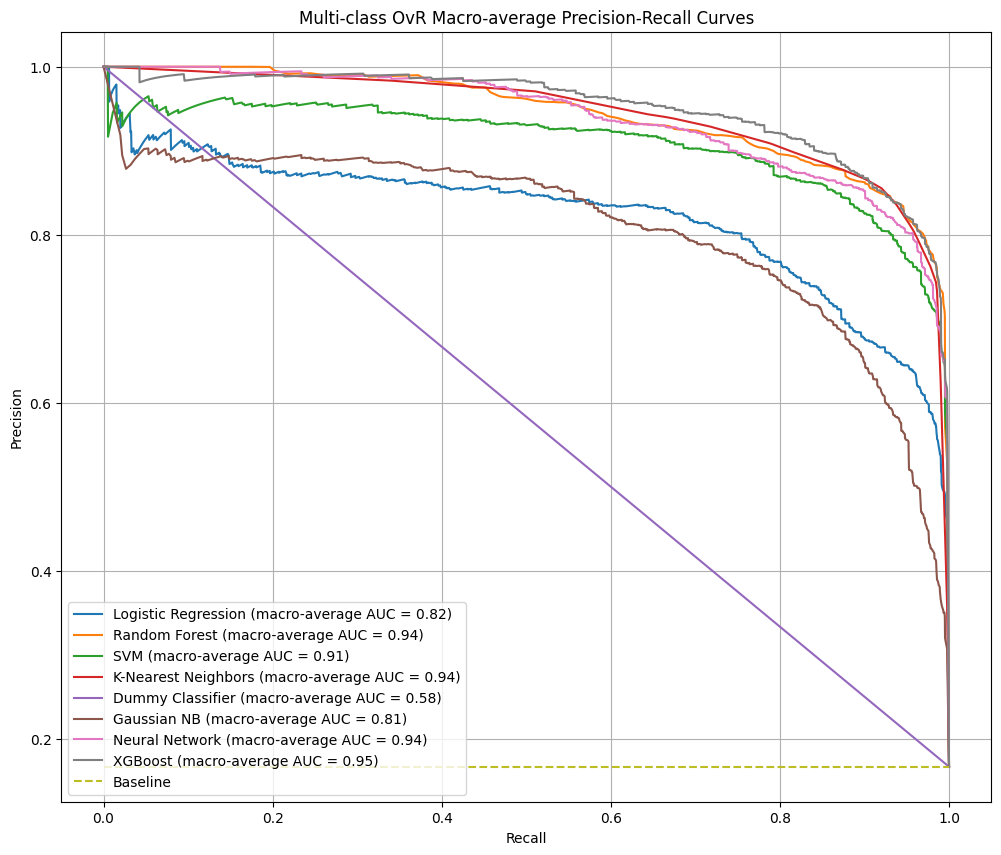

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

n_classes = y_true.shape[1]  # Number of classes

plt.figure(figsize=(12, 10))

for name, y_score in model_scores.items():
    precision = dict()
    recall = dict()
    pr_auc = dict()

    # Compute Precision-Recall curve and AUC for each class
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_score[:, i])
        pr_auc[i] = auc(recall[i], precision[i])

    # Create a unified recall grid for interpolation
    all_recall = np.unique(np.concatenate([recall[i] for i in range(n_classes)]))
    mean_precision = np.zeros_like(all_recall)

    # Interpolate precisions on the unified recall grid and average
    for i in range(n_classes):
        # Reverse recall and precision arrays for interpolation (monotonically increasing recall)
        mean_precision += np.interp(all_recall, recall[i][::-1], precision[i][::-1])
    mean_precision /= n_classes

    # Plot macro-average PR curve
    plt.plot(all_recall, mean_precision, label=f'{name} (macro-average AUC = {np.mean(list(pr_auc.values())):.2f})')

# Plot baseline: precision of a random classifier (ratio of positive samples)
baseline = np.sum(y_true) / y_true.size
plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-class OvR Macro-average Precision-Recall Curves')
plt.legend(loc='lower left')
plt.grid()
plt.show()


Among all models, the Random Forest, K-Nearest Neighbors, and Neural Network classifiers achieved the highest macro-averaged precision–recall AUC of 0.94. This shows their strong ability to retain high precision even at large recall values.The Dummy Classifier showed the lowest performance (AUC = 0.58), with its curve dropping sharply as recall increased. This is expected from the untrained model whose predictions are close to random, leading to poor precision at higher recall levels.

Across all metrics, the Random Forest, Neural Network, and K-Nearest Neighbors models consistently perform the best. The Random Forest, shows the highest ROC-AUC (0.99) and PRC (0.94), indicating strong class separation and best precision–recall balance.

However, the rankings don’t perfectly align for all models. For example, models like Logistic Regression and Gaussian Naïve Bayes have decent ROC-AUC values but lower PRC-AP scores. This happens as ROC-AUC measures how well a model separates classes overall, while PRC focuses more on how accurately it identifies positives under class imbalance. A model can have a high ROC-AUC but still perform poorly in PRC if it produces many false positives when recall is increased.

Based on all three metrics, the Random Forest classifier is the most reliable choice. It maintains high precision and recall across thresholds, making it effective for both balanced and imbalanced data. The Neural Network and KNN also perform well, but Random Forest offers the best overall trade-off .

# **Bonus**

Among all classifiers tested, Random Forest and XGBoost demonstrated the best discriminative performance, both achieving a macro-average AUC of 0.99. Their ROC curves lie extremely close to the top-left corner, indicating that these ensemble models effectively balance sensitivity and specificity across all classes. This performance reflects their strong ability to capture nonlinear relationships and handle class imbalance efficiently through tree-based boosting and aggregation.

Logistic Regression (Flipped), intentionally inverted to represent a poorly performing baseline, yielded a macro-average AUC of 0.04. Its curve lies below the random classifier line, confirming that its predictions are systematically incorrect.



In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression

results = []

# Binarize true labels for ROC/PRC (One-vs-Rest style)
y_true = label_binarize(y_test, classes=np.unique(y_train))

# Adding flipped Logistic Regression model to models dict
base_lr = LogisticRegression(max_iter=1000, multi_class='ovr')
flipped_lr_name = 'Flipped Logistic Regression'

# Fit base Logistic Regression for flipping probabilities
base_lr.fit(X_train, y_train)
# Predict flipped probabilities
y_score_flipped = 1 - base_lr.predict_proba(X_test)
# Get predicted classes from flipped probabilities (argmax)
y_pred_flipped = np.argmax(y_score_flipped, axis=1)
# Map back to original class labels
classes = base_lr.classes_
y_pred_flipped_labels = classes[y_pred_flipped]

# Calculate accuracy and weighted F1 for flipped model
acc_flipped = accuracy_score(y_test, y_pred_flipped_labels)
f1_w_flipped = f1_score(y_test, y_pred_flipped_labels, average='weighted')

# Store flipped model results
results.append({
    'Model': flipped_lr_name,
    'Accuracy': acc_flipped,
    'Weighted F1-Score': f1_w_flipped,
    'y_score': y_score_flipped
})

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1_w = f1_score(y_test, y_pred, average='weighted')

    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Weighted F1-Score': f1_w,
        'y_score': y_score
    })

results_df = pd.DataFrame([
    {'Model': r['Model'], 'Accuracy': r['Accuracy'], 'Weighted F1-Score': r['Weighted F1-Score']}
    for r in results
])

print(results_df)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [07:45:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                         Model  Accuracy  Weighted F1-Score
0  Flipped Logistic Regression  0.000518           0.000227
1          Logistic Regression  0.838426           0.811908
2                Random Forest  0.917141           0.914235
3                          SVM  0.897462           0.895996
4          K-Nearest Neighbors  0.910927           0.909984
5             Dummy Classifier  0.238219           0.091661
6                  Gaussian NB  0.793371           0.800111
7               Neural Network  0.899534           0.897629
8                      XGBoost  0.917141           0.915578


In [ ]:
model_scores = {}

# Add flipped Logistic Regression
model_scores[flipped_lr_name] = y_score_flipped

# Existing loop for other models
for name, model in models.items():
    model.fit(X_train, y_train)
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)
    model_scores[name] = y_score


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [07:53:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


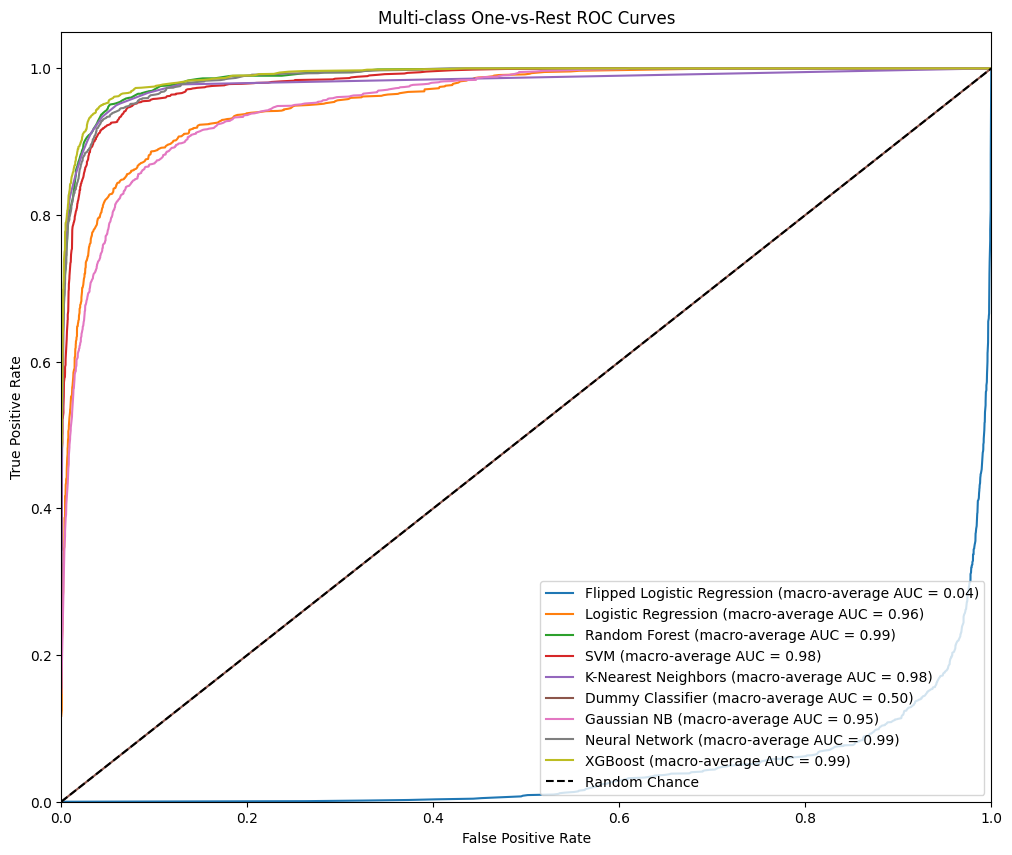

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

n_classes = y_true.shape[1]

plt.figure(figsize=(12, 10))

for name, y_score in model_scores.items():
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot macro-average ROC curve
    plt.plot(fpr["macro"], tpr["macro"],
             label=f'{name} (macro-average AUC = {roc_auc["macro"]:0.2f})')

# Plot diagonal line for random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class One-vs-Rest ROC Curves')
plt.legend(loc="lower right")
plt.show()


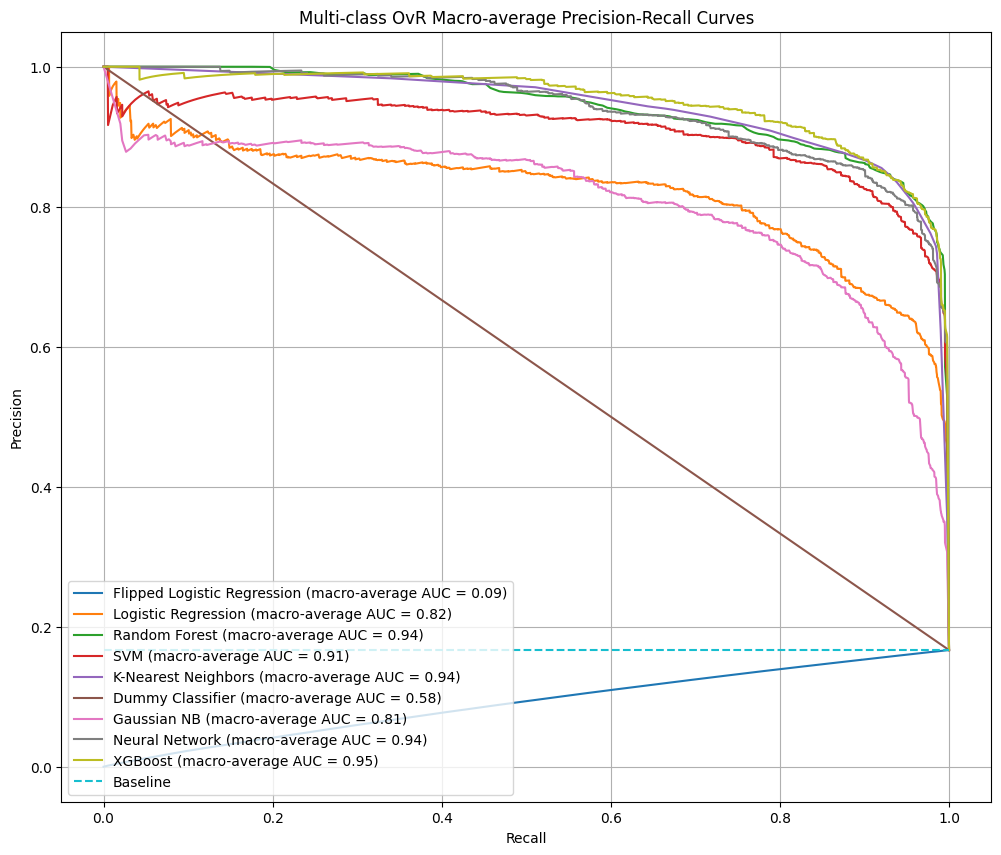

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

n_classes = y_true.shape[1]  # Number of classes

plt.figure(figsize=(12, 10))

for name, y_score in model_scores.items():
    precision = dict()
    recall = dict()
    pr_auc = dict()

    # Compute Precision-Recall curve and AUC for each class
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_score[:, i])
        pr_auc[i] = auc(recall[i], precision[i])

    # Create a unified recall grid for interpolation
    all_recall = np.unique(np.concatenate([recall[i] for i in range(n_classes)]))
    mean_precision = np.zeros_like(all_recall)

    # Interpolate precisions on the unified recall grid and average
    for i in range(n_classes):
        # Reverse recall and precision arrays for interpolation (monotonically increasing recall)
        mean_precision += np.interp(all_recall, recall[i][::-1], precision[i][::-1])
    mean_precision /= n_classes

    # Plot macro-average PR curve
    plt.plot(all_recall, mean_precision, label=f'{name} (macro-average AUC = {np.mean(list(pr_auc.values())):.2f})')

# Plot baseline: precision of a random classifier (ratio of positive samples)
baseline = np.sum(y_true) / y_true.size
plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-class OvR Macro-average Precision-Recall Curves')
plt.legend(loc='lower left')
plt.grid()
plt.show()
